In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.figure_factory as ff
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.discriminant_analysis import StandardScaler
import category_encoders as ce
from sklearn.pipeline import Pipeline
from category_encoders import TargetEncoder, HashingEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
import xgboost as xgb
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report, accuracy_score
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
import numpy as np
import time


In [ ]:


def evaluate_model(X_train, y_test, y_pred, y_probs=None):
    # General Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}\n")
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Default', 'Default'], yticklabels=['Non-Default', 'Default'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    # Classification Report
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    # ROC Curve for each class (only if probability predictions are available)
    if y_probs is not None:
        fpr_0, tpr_0, _ = roc_curve(y_test, y_probs[:, 0])  # Class 0
        fpr_1, tpr_1, _ = roc_curve(y_test, y_probs[:, 1])  # Class 1
        
        auc_0 = auc(fpr_0, tpr_0)
        auc_1 = auc(fpr_1, tpr_1)
        
        plt.figure(figsize=(6, 5))
        plt.plot(fpr_0, tpr_0, color='blue', lw=2, label=f'Class 0 ROC Curve (AUC = {auc_0:.2f})')
        plt.plot(fpr_1, tpr_1, color='red', lw=2, label=f'Class 1 ROC Curve (AUC = {auc_1:.2f})')
        plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
        plt.title('Receiver Operating Characteristic (ROC) Curves')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc='lower right')
        plt.show()


In [149]:
data = pd.read_csv('data.csv')

In [150]:
data

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000.0,1,3,1,39,0,0,0,0,...,88004.0,31237.0,15980.0,8500.0,20000.0,5003.0,3047.0,5000.0,1000.0,0
29996,29997,150000.0,1,3,2,43,-1,-1,-1,-1,...,8979.0,5190.0,0.0,1837.0,3526.0,8998.0,129.0,0.0,0.0,0
29997,29998,30000.0,1,2,2,37,4,3,2,-1,...,20878.0,20582.0,19357.0,0.0,0.0,22000.0,4200.0,2000.0,3100.0,1
29998,29999,80000.0,1,3,1,41,1,-1,0,0,...,52774.0,11855.0,48944.0,85900.0,3409.0,1178.0,1926.0,52964.0,1804.0,1


In [151]:
data = data.drop(columns=['ID','SEX', 'EDUCATION', 'MARRIAGE', 'AGE'])

In [152]:
bill_columns = ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']
mask = (data[bill_columns] >= 0).all(axis=1)
data = data[mask]

In [153]:
data.head()

,LIMIT_BAL,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,20000.0,2,2,-1,-1,-2,-2,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,120000.0,-1,2,0,0,0,2,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,90000.0,0,0,0,0,0,0,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,50000.0,0,0,0,0,0,0,46990.0,48233.0,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,50000.0,-1,0,-1,0,0,0,8617.0,5670.0,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [154]:
print(data.describe())

            LIMIT_BAL         PAY_0         PAY_2         PAY_3         PAY_4  \
count    28070.000000  28070.000000  28070.000000  28070.000000  28070.000000   
mean    164443.522622      0.012611     -0.074207     -0.111115     -0.164125   
std     128985.392370      1.112784      1.185770      1.183514      1.159742   
min      10000.000000     -2.000000     -2.000000     -2.000000     -2.000000   
25%      50000.000000     -1.000000     -1.000000     -1.000000     -1.000000   
50%     140000.000000      0.000000      0.000000      0.000000      0.000000   
75%     230000.000000      0.000000      0.000000      0.000000      0.000000   
max    1000000.000000      8.000000      8.000000      8.000000      8.000000   

              PAY_5         PAY_6      BILL_AMT1      BILL_AMT2  \
count  28070.000000  28070.000000   28070.000000   28070.000000   
mean      -0.210937     -0.234129   53623.147987   51601.967866   
std        1.125336      1.141169   74554.826995   72144.853055   
mi

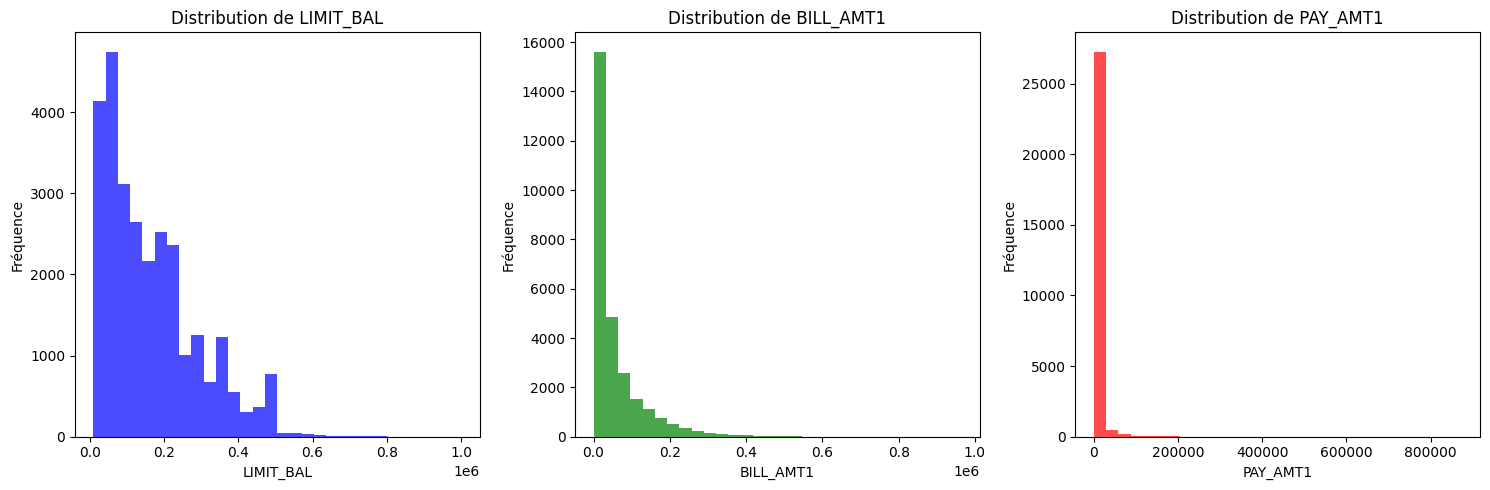

In [155]:
# Histogrammes pour quelques colonnes numériques
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(data['LIMIT_BAL'], bins=30, color='blue', alpha=0.7)
plt.title('Distribution de LIMIT_BAL')
plt.xlabel('LIMIT_BAL')
plt.ylabel('Fréquence')

plt.subplot(1, 3, 2)
plt.hist(data['BILL_AMT1'], bins=30, color='green', alpha=0.7)
plt.title('Distribution de BILL_AMT1')
plt.xlabel('BILL_AMT1')
plt.ylabel('Fréquence')

plt.subplot(1, 3, 3)
plt.hist(data['PAY_AMT1'], bins=30, color='red', alpha=0.7)
plt.title('Distribution de PAY_AMT1')
plt.xlabel('PAY_AMT1')
plt.ylabel('Fréquence')

plt.tight_layout()
plt.show()

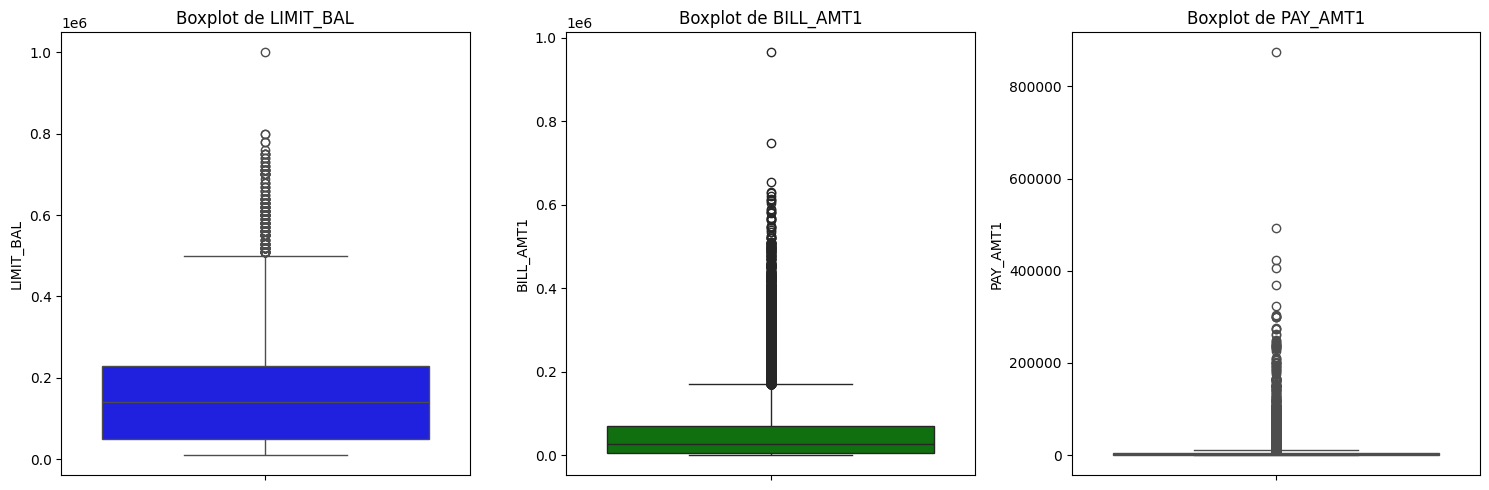

In [156]:
# Boxplots pour détecter les outliers
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.boxplot(y=data['LIMIT_BAL'], color='blue')
plt.title('Boxplot de LIMIT_BAL')

plt.subplot(1, 3, 2)
sns.boxplot(y=data['BILL_AMT1'], color='green')
plt.title('Boxplot de BILL_AMT1')

plt.subplot(1, 3, 3)
sns.boxplot(y=data['PAY_AMT1'], color='red')
plt.title('Boxplot de PAY_AMT1')

plt.tight_layout()
plt.show()

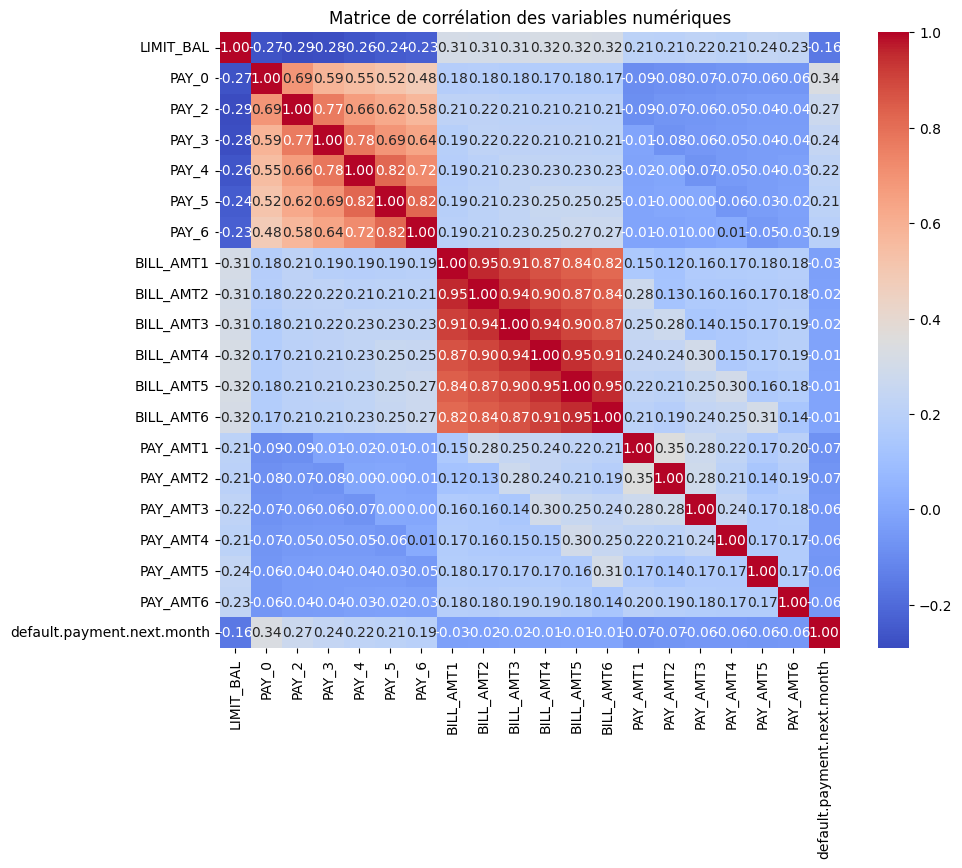

In [157]:
# Heatmap de corrélation
plt.figure(figsize=(10, 8))
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matrice de corrélation des variables numériques')
plt.show()

In [158]:
numeric_columns = ['LIMIT_BAL', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
                   'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

In [159]:

# Assuming your dataset is loaded as 'data'
# Check value counts
print(data['default.payment.next.month'].value_counts())

# Optional: Check the percentage too
print(data['default.payment.next.month'].value_counts(normalize=True) * 100)


default.payment.next.month
0    21752
1     6318
Name: count, dtype: int64
default.payment.next.month
0    77.491984
1    22.508016
Name: proportion, dtype: float64


In [160]:
# Assuming your dataset is 'data'

# Find columns where there is at least one negative value
negative_columns = [col for col in data.columns if (data[col] < 0).any()]

print("Columns with negative values:", negative_columns)


Columns with negative values: ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']


In [161]:
# Features (X): everything except the target
X = data.drop(columns=['default.payment.next.month'])

# Target (y): the target column
y = data['default.payment.next.month']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [162]:
# Apply SMOTE for balancing the classes in the training data
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Standardize the features for better performance with models like Logistic Regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)




In [168]:
# Initialize and train the Logistic Regression model
lr_model = LogisticRegression(class_weight='balanced', random_state=42)
lr_model.fit(X_train_scaled, y_train_res)
y_pred_lr = lr_model.predict(X_test_scaled)
y_probs_lr = lr_model.predict_proba(X_test_scaled)  # Probabilities for ROC curve


In [177]:
# calculate scale_pos_weight
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

xgb_model = xgb.XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_estimators=500,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='logloss'
)
xgb_model.fit(X_train_scaled, y_train_res)
y_pred_xgb = xgb_model.predict(X_test)
y_probs_xgb = xgb_model.predict_proba(X_test_scaled)  # Probabilities for ROC curve

C:\Users\melom\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\xgboost\core.py:158: UserWarning:

[15:44:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.




In [170]:
# Initialize and train the Random Forest model
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_model.fit(X_train_scaled, y_train_res)
y_pred_rf = rf_model.predict(X_test_scaled)
y_probs_rf = rf_model.predict_proba(X_test_scaled)  # Probabilities for ROC curve


Logistic Regression Evaluation:
Accuracy: 0.6537



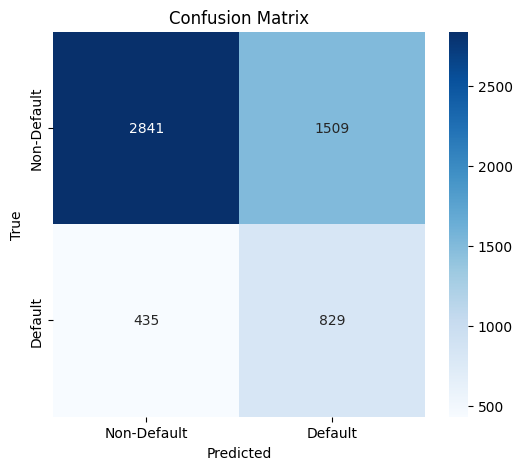

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.65      0.75      4350
           1       0.35      0.66      0.46      1264

    accuracy                           0.65      5614
   macro avg       0.61      0.65      0.60      5614
weighted avg       0.75      0.65      0.68      5614



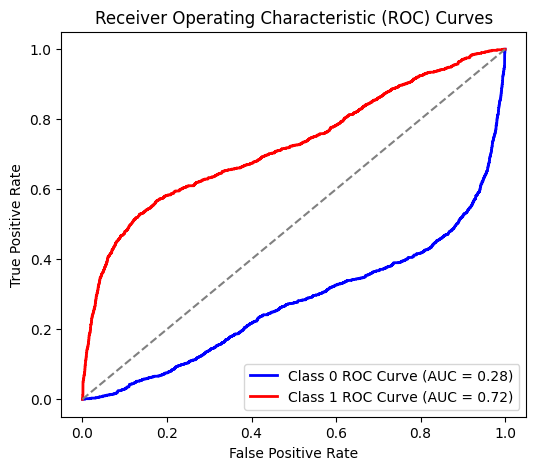

XGBoost Evaluation:
Accuracy: 0.7870



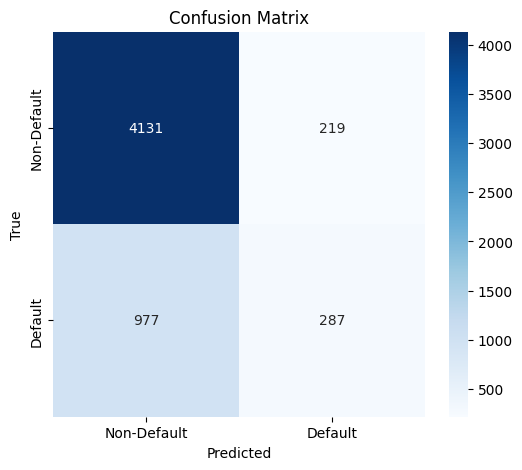

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.95      0.87      4350
           1       0.57      0.23      0.32      1264

    accuracy                           0.79      5614
   macro avg       0.69      0.59      0.60      5614
weighted avg       0.75      0.79      0.75      5614



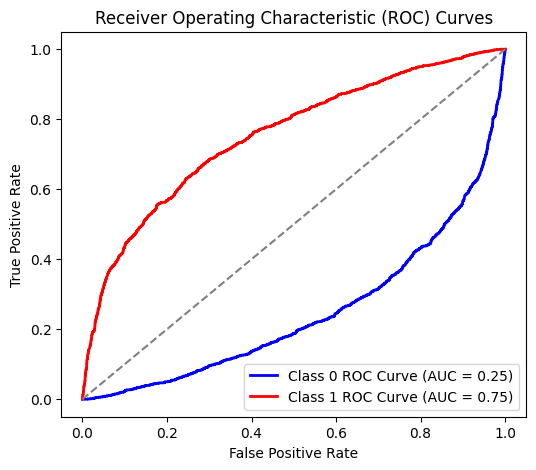

Random Forest Evaluation:
Accuracy: 0.7823



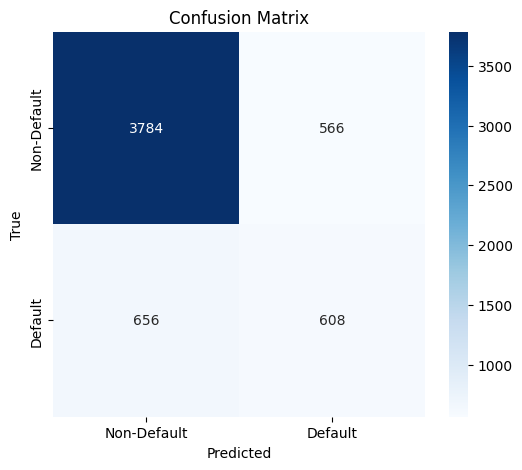

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.87      0.86      4350
           1       0.52      0.48      0.50      1264

    accuracy                           0.78      5614
   macro avg       0.69      0.68      0.68      5614
weighted avg       0.78      0.78      0.78      5614



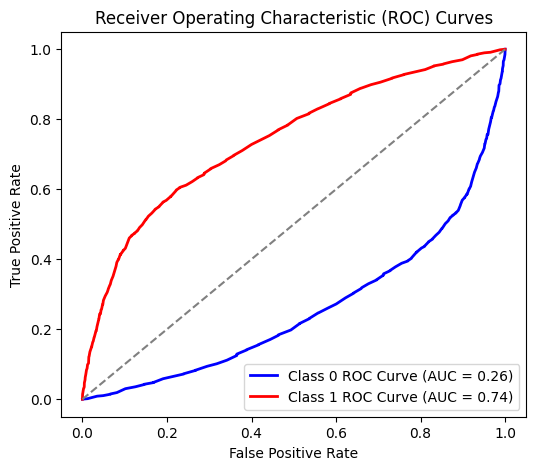

In [179]:
# Evaluate Logistic Regression
print("Logistic Regression Evaluation:")
evaluate_model(X_train_scaled, y_test, y_pred_lr, y_probs_lr)

# Evaluate XGBoost
print("XGBoost Evaluation:")
y_pred_new = (y_probs_xgb[:, 1] > 0.3).astype(int)

evaluate_model(X_train_scaled, y_test, y_pred_xgb, y_probs_xgb)

# Evaluate Random Forest
print("Random Forest Evaluation:")
evaluate_model(X_train_scaled, y_test, y_pred_rf, y_probs_rf)


In [172]:
param_grid = {'max_depth': [3, 5, 7], 'n_estimators': [50, 100, 150]}
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5)
grid_search.fit(X_train_scaled, y_train_res)
print("Best Parameters: ", grid_search.best_params_)


Best Parameters:  {'max_depth': 7, 'n_estimators': 150}
